# Exercise 1: TwoLayer Network (PyTorch)
Many codes for research papers are based in PyTorch or Tensorflow. These libraries provide automatic differential system and allow tensor computation with strong acceleration via GPU, which helps to build and train Deep learning model.[1]  However, the adoption of PyTorch was extremely rapid and, in just a few years, grew to use in almost 80% of papers that use either PyTorch or TensorFlow. [2]

In this assignment, we will learn how to use __PyTorch__ __framework__ by training Twolayer Network which was already done in HW1. The model structure is same with the structure we've already done in HW1.

[1] https://en.wikipedia.org/wiki/PyTorch

[2] https://www.assemblyai.com/blog/pytorch-vs-tensorflow-in-2023/

First, let's check if you are properly using GPU
- Ouput should be 'True'
- If not, please follow the instructions in ETL.

In [1]:
import torch
use_cuda = torch.cuda.is_available()
print('GPU available?:', use_cuda)

GPU available?: True


Next, let's mount your drive directory to current notebook and change the system directory to your working directory

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Intro_dl/hw1')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Intro_dl/hw1')

Mounted at /content/drive


In [3]:
import torch
from utils import *

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## Data Content (CIFAR10)
we will use the CIFAR10 dataset, which was already used for HW1.

In [4]:
X_tr, Y_tr, X_te, Y_te, mean_img = get_CIFAR10_data()
print ('Train data shape : %s,  Train labels shape : %s' % (X_tr.shape, Y_tr.shape))
print ('Test data shape : %s,  Test labels shape : %s' % (X_te.shape, Y_te.shape))

Train data shape : (10000, 3072),  Train labels shape : (10000,)
Test data shape : (1000, 3072),  Test labels shape : (1000,)


Visualize the training images

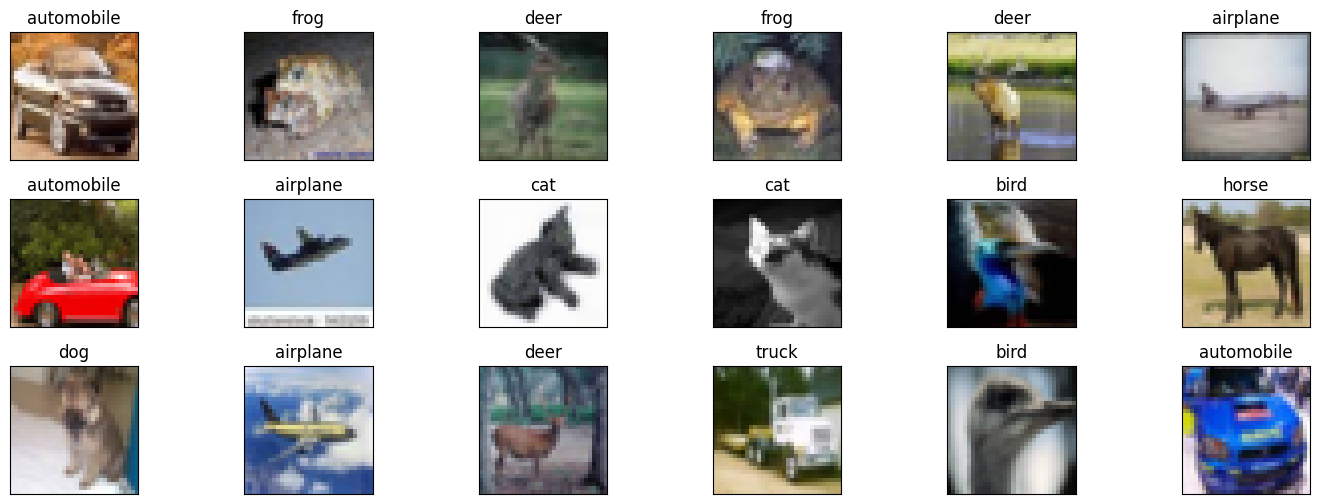

In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

images_index = np.int32(np.round(np.random.rand(18,)*10000,0))

fig, axes = plt.subplots(3, 6, figsize=(18, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)

for ax, idx in zip(axes.flat, images_index):
    img = (X_tr[idx,:3072].reshape(32, 32, 3) + mean_img.reshape(32, 32, 3))
    ax.imshow(img)
    ax.set_title(class_names[Y_tr[idx]])


In [6]:


X_tr, Y_tr, X_te, Y_te = torch.tensor(X_tr), torch.tensor(Y_tr), torch.tensor(X_te), torch.tensor(Y_te)

batch_size = 100

# Dataset
train_ds = TensorDataset(X_tr, Y_tr)
test_ds = TensorDataset(X_te, Y_te)

# Dataloader
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

## Building Models with PyTorch

There are two important functions to know when we build up models using PyTorch library : __init__() and __forward__().

__init__() sets up the network’s structure by defining the layers, while __forward__() specifies how the data flows through the network. Both methods are required to create a neural network in PyTorch and serve different purposes. [1]

1. __init__()

__init__ is a constructor method used to initialize the parameters of the network. It is executed when an object of the class is created. For example, in PyTorch, this method is used to define the layers of the network, such as convolutional layers, linear layers, activation functions, etc.

2. __forward__()

forward is the method that defines the forward pass of the neural network. This method takes the input data and passes it through the layers of the network to produce the output. This method is executed whenever the model is called to make a prediction or to compute the loss during training.

For further details, please read [2]

[1] https://discuss.pytorch.org/t/what-is-the-difference-init-and-forward-in-a-network-model/173907

[2] https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html

### To do:
- Implement missing codes in `Building Models with Pytorch`.
- Design guide (__Strictly requried__)
    - Follow the structure of `TwolayerNet` implemented in `HW_YourAnswer.py`
        - " Input => Fully Connected => ReLU => Fully Connected => OutputLayer "
    - Hidden dimension : 1024

- Find and use torch modules for required structure(softmax, relu, ..). (https://pytorch.org/docs/stable/nn.html)

In [7]:
import torch.nn as nn

# ========================================== WRITE YOUR CODE ========================================== #

# Instructions:
#     - Implement TwoLayerNet using torch module.
#     - Please read [2] (https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html) for further details
#     - The 'TwolayerNet' class should 2 functions : 1) __init__ 2) forward
#     - Model Structure would be like
#       " Input => Fully Connected => ReLU => Fully Connected => OutputLayer "

 # ======================================================================================================
class TwolayerNet(nn.Module):
  def __init__(self):
    super(TwolayerNet, self).__init__()

    self.FC1 = nn.Linear(3072, 1024)
    self.activation = nn.ReLU()
    self.FC2 = nn.Linear(1024, 10)
    self.softmax = nn.Softmax()

  def forward(self, x):
    x = self.FC1(x)
    x = self.activation(x)
    x = self.FC2(x)
    # x = self.softmax(x)

    return x

## Setting Hyperparameters
Here, we manually set hyperparameters(epochs, lr, ..) that are used for training the model. Hyper-parameters are one of the important factor to train a model up to targeting performance. Batch size which is defined above is also an important hyper-parameter for training Neural Network.

In [8]:
epochs = 40
lr = 0.1
weight_decay = 0.0001

model = TwolayerNet().cuda()
optimizer = torch.optim.SGD(params = model.parameters(), lr = lr, weight_decay=weight_decay)


loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')

## Training

In [9]:
train_acc = []
test_acc = []

for epoch in range(epochs):
    model.train()
    train_correct = 0
    test_correct = 0
    epoch_loss = 0

    # train
    for data in train_loader:
        img, label = data

        img = img.type(torch.FloatTensor).cuda()
        label = label.type(torch.LongTensor).cuda()

        optimizer.zero_grad()

        pred = model(img)

        train_correct += (pred.argmax(dim = 1) == label).sum().item()

        loss = loss_fn(pred, label)
        epoch_loss += loss.item() * batch_size

        loss.backward()
        optimizer.step()

    # eval
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            img, label = data
            img = img.type(torch.FloatTensor).cuda()
            label = label.cuda()
            pred = model(img.flatten(1))

            test_correct += (pred.argmax(dim = 1) == label).sum().item()

    train_acc.append(train_correct / len(train_loader.dataset))
    test_acc.append(test_correct/len(test_loader.dataset))

    print(f'Epoch: {epoch}, Training acc: {train_correct / len(train_loader.dataset):.3f}, Test acc : {test_correct / len(test_loader.dataset):.3f}')

Epoch: 0, Training acc: 0.307, Test acc : 0.373
Epoch: 1, Training acc: 0.395, Test acc : 0.405
Epoch: 2, Training acc: 0.432, Test acc : 0.405
Epoch: 3, Training acc: 0.461, Test acc : 0.430
Epoch: 4, Training acc: 0.484, Test acc : 0.436
Epoch: 5, Training acc: 0.506, Test acc : 0.454
Epoch: 6, Training acc: 0.524, Test acc : 0.439
Epoch: 7, Training acc: 0.543, Test acc : 0.466
Epoch: 8, Training acc: 0.562, Test acc : 0.458
Epoch: 9, Training acc: 0.581, Test acc : 0.480
Epoch: 10, Training acc: 0.603, Test acc : 0.467
Epoch: 11, Training acc: 0.621, Test acc : 0.470
Epoch: 12, Training acc: 0.637, Test acc : 0.472
Epoch: 13, Training acc: 0.657, Test acc : 0.453
Epoch: 14, Training acc: 0.677, Test acc : 0.493
Epoch: 15, Training acc: 0.695, Test acc : 0.472
Epoch: 16, Training acc: 0.712, Test acc : 0.487
Epoch: 17, Training acc: 0.726, Test acc : 0.471
Epoch: 18, Training acc: 0.743, Test acc : 0.471
Epoch: 19, Training acc: 0.762, Test acc : 0.481
Epoch: 20, Training acc: 0.772

## Evaluation

In [10]:
n_correct = 0
for data in test_loader:
    img, label = data
    img = img.type(torch.FloatTensor).cuda()
    label = label.cuda()
    pred = model(img.flatten(1))

    n_correct += (pred.argmax(dim = 1) == label).sum().item()

print(f"Final Test Accuracy: {n_correct / len(test_loader.dataset):.3f}")

Final Test Accuracy: 0.464


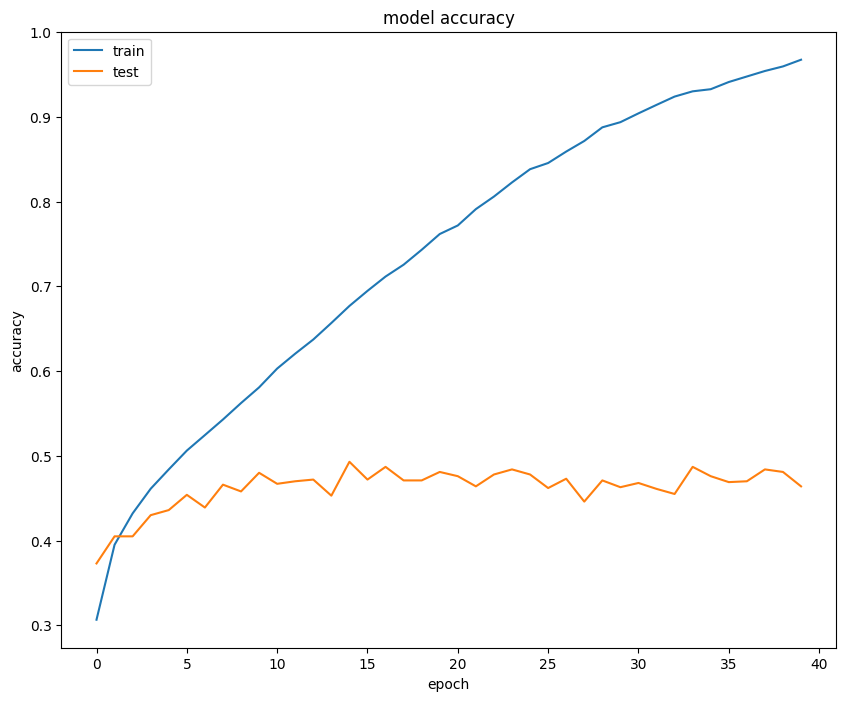

In [11]:
model_plot(train_acc,test_acc)